In [2]:

"""Knowledge Distllation Method"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataloader as Data
import torchvision #torchvision模块包括了一些图像数据集,如MNIST,cifar10等
import matplotlib.pyplot as plt

In [3]:
"""准备数据"""

# 所有的torchvision.datasets数据集的类都是torch.utils.data.Dataset的子类,实现了__getitem__和__len__方法。故可传递给torch.utils.data.DataLoader来加载
# 创建用于Train的数据集,若root目录无数据集,则Download;若root目录有数据集,则从PIL图像数据转换为Tensor
train_data = torchvision.datasets.MNIST(root='./mnist',train=True,transform=torchvision.transforms.ToTensor(),download=True)
test_data  = torchvision.datasets.MNIST(root='./mnist',train=False,transform=torchvision.transforms.ToTensor())
print("train_data:",train_data.data.size())
print(len(train_data))
print("train_labels:",train_data.targets.size())
print("test_data:",test_data.data.size())

# 根据数据集创建响应的dataLoader
# shuffle（bool, 可选) – 如果每一个epoch内要打乱数据，就设置为True（默认：False）
train_loader = Data.DataLoader(dataset=train_data, batch_size=50, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=500, shuffle=False)
print(train_loader)

train_data: torch.Size([60000, 28, 28])
60000
train_labels: torch.Size([60000])
test_data: torch.Size([10000, 28, 28])


In [162]:
"""创建模型"""

class CNN(nn.Module):  # 定义了一个类,名字叫CNN
    #注意: 在模型中必须要定义 `forward` 函数，`backward` 函数（用来计算梯度）会被`autograd`自动创建。 可以在 `forward` 函数中使用任何针对 `Tensor` 的操作。
    def __init__(self):  # 每个类都必须有的构造函数，用来初始化该类
        super(CNN, self).__init__() # 先调用父类的构造函数
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        # 本函数配置了卷积层和全连接层的维度
        # Conv2d(in_cahnnels, out_channels, kernel_size, stride, padding=0 ,...)
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2) # 卷积层1: 二维卷积层, 1x28x28,16x28x28, 卷积核大小为5x5
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2) # 卷积层2: 二维卷积层, 16x14x14,32x14x14, 卷积核大小为5x5
        # an affine(仿射) operation: y = Wx + b # 全连接层1: 线性层, 输入维度32x7x7,输出维度128
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10) # 全连接层2: 线性层, 输入维度128,输出维度10

    def forward(self, x): #定义了forward函数
        # Max pooling over a (2, 2) window 
        conv1_out = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # 先卷积,再池化
        # If the size is a square you can only specify a single number
        conv2_out = F.max_pool2d(F.relu(self.conv2(conv1_out)), 2)  # 再卷积,再池化
        res = conv2_out.view(conv2_out.size(0), -1)  # 将conv3_out展开成一维(扁平化)
        fc1_out = F.relu(self.fc1(res)) # 全连接1
        out = self.fc2(fc1_out) # 全连接2
        
        #return out
        #return F.log_softmax(out),fc1_out #返回softmax后的Tensor,以及倒数第二层的Tensor(以进行低维Tensor的可视化)
        return F.log_softmax(out,dim=0),fc1_out
    
cnn = CNN() #新建了一个CNN对象,其实是一系列的函数/方法的集合
cnn = cnn.cuda() #*.cuda()将模型的所有参数和缓存移动到GPU
print(cnn)



def plot_with_labels(lowDWeights, labels):
    plt.cla() #clear当前活动的坐标轴
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1] #把Tensor的第1列和第2列,也就是TSNE之后的前两个特征提取出来,作为X,Y
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9));
        #plt.text(x, y, s, backgroundcolor=c, fontsize=9)
        plt.text(x, y, str(s),color=c,fontdict={'weight': 'bold', 'size': 9}) #在指定位置放置文本
    plt.xlim(X.min(), X.max());
    plt.ylim(Y.min(), Y.max());
    plt.title('Visualize last layer');
    plt.show();
    plt.pause(0.01)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [163]:
"""定义损失函数-这里默认是交叉熵函数"""

loss_func = torch.nn.CrossEntropyLoss()

"""初始化:优化器"""

optimizer = optim.Adam(cnn.parameters(), lr=0.01)  #list(cnn.parameters())会给出一个参数列表,记录了所有训练参数(W和b)的数据
#optimizer =optim.Adam([ {'params': cnn.conv1.weight}, {'params': cnn.conv1.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.conv2.weight}, {'params': cnn.conv2.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.fc1.weight}, {'params': cnn.fc1.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.fc2.weight}, {'params': cnn.fc2.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.conv3.weight}, {'params': cnn.conv3.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.conv4.weight}, {'params': cnn.conv4.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.conv5.weight}, {'params': cnn.conv5.bias, 'lr': 0.002,'weight_decay': 0 },], lr=0.001, weight_decay=0.0001)


In [164]:
"""训练"""

def train(epoch):
    print('epoch {}'.format(epoch))
    #直接初始化为0的是标量,tensor调用item()将返回标量值
    train_loss = 0
    train_acc = 0
    #step是enumerate（）函数自带的索引，从0开始
    for step, (batch_x, batch_y) in enumerate(train_loader):
        # 把batch_x和batth_y移动到GPU
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        # 正向传播
        out,_ = cnn(batch_x)
        loss = loss_func(out, batch_y)
        train_loss += loss.item()
        # torch.max(tensor,dim:int):tensor找到第dim维度(第0维度是数据下标)上的最大值
        # return: 第一个Tensor是该维度的最大值,第二个Tensor是最大值相应的下标
        pred = torch.max(out, 1)[1]
        # 直接对逻辑量进行sum,将返回True的个数
        train_correct = (pred == batch_y).sum()
        train_acc += train_correct.item()
        if step % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, step * len(batch_x), len(train_loader.dataset),100. * step / len(train_loader), loss.item()))

        #反向传播
        optimizer.zero_grad() # 所有参数的梯度清零
        loss.backward() #即反向传播求梯度
        optimizer.step() #调用optimizer进行梯度下降更新参数
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(train_data)), train_acc / (len(train_data))))

from matplotlib import cm
try:
    from sklearn.manifold import TSNE; HAS_SK = True
except:
    HAS_SK = False; print('Please install sklearn for layer visualization')

epoch 1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295790
Train Epoch: 1 [1000/60000 (2%)]	Loss: 0.484218
Train Epoch: 1 [2000/60000 (3%)]	Loss: 0.313150
Train Epoch: 1 [3000/60000 (5%)]	Loss: 0.372041
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.326063
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.222827
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.151755
Train Epoch: 1 [7000/60000 (12%)]	Loss: 0.281703
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.564277
Train Epoch: 1 [9000/60000 (15%)]	Loss: 0.107382
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.219432
Train Epoch: 1 [11000/60000 (18%)]	Loss: 0.514538
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.210952
Train Epoch: 1 [13000/60000 (22%)]	Loss: 0.078136
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.073231
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.285422
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.074081
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.216135
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.105947
Train Epoch: 1 [19000/60000 (32%)]	Loss: 0.153898
Train Epoch

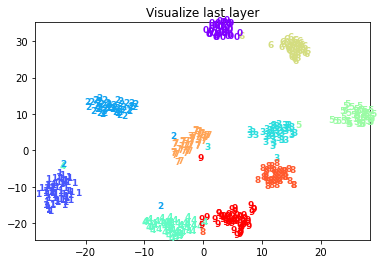

Test Loss: 0.000164, Accuracy: 9756/10000 (97.56%
epoch 2
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.084860
Train Epoch: 2 [1000/60000 (2%)]	Loss: 0.282999
Train Epoch: 2 [2000/60000 (3%)]	Loss: 0.040983
Train Epoch: 2 [3000/60000 (5%)]	Loss: 0.069682
Train Epoch: 2 [4000/60000 (7%)]	Loss: 0.030459
Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.377289
Train Epoch: 2 [6000/60000 (10%)]	Loss: 0.094695
Train Epoch: 2 [7000/60000 (12%)]	Loss: 0.023050
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.146964
Train Epoch: 2 [9000/60000 (15%)]	Loss: 0.135125
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.187271
Train Epoch: 2 [11000/60000 (18%)]	Loss: 0.202462
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.159136
Train Epoch: 2 [13000/60000 (22%)]	Loss: 0.023574
Train Epoch: 2 [14000/60000 (23%)]	Loss: 0.004150
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.170718
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.081514
Train Epoch: 2 [17000/60000 (28%)]	Loss: 0.026426
Train Epoch: 2 [18000/60000 (30%)]	Loss: 0.119068
Train Epoch

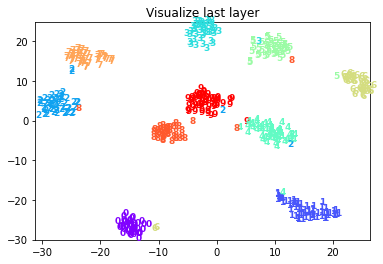

Test Loss: 0.000160, Accuracy: 9759/10000 (97.59%
epoch 3
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.055713
Train Epoch: 3 [1000/60000 (2%)]	Loss: 0.206966
Train Epoch: 3 [2000/60000 (3%)]	Loss: 0.064141
Train Epoch: 3 [3000/60000 (5%)]	Loss: 0.066758
Train Epoch: 3 [4000/60000 (7%)]	Loss: 0.021859
Train Epoch: 3 [5000/60000 (8%)]	Loss: 0.095586
Train Epoch: 3 [6000/60000 (10%)]	Loss: 0.080674
Train Epoch: 3 [7000/60000 (12%)]	Loss: 0.003472
Train Epoch: 3 [8000/60000 (13%)]	Loss: 0.029189
Train Epoch: 3 [9000/60000 (15%)]	Loss: 0.052511
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.114154
Train Epoch: 3 [11000/60000 (18%)]	Loss: 0.046324
Train Epoch: 3 [12000/60000 (20%)]	Loss: 0.017896
Train Epoch: 3 [13000/60000 (22%)]	Loss: 0.004155
Train Epoch: 3 [14000/60000 (23%)]	Loss: 0.081422
Train Epoch: 3 [15000/60000 (25%)]	Loss: 0.121200
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.207233
Train Epoch: 3 [17000/60000 (28%)]	Loss: 0.139253
Train Epoch: 3 [18000/60000 (30%)]	Loss: 0.017290
Train Epoch

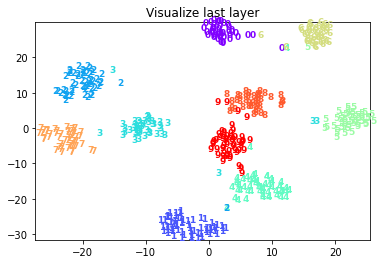

Test Loss: 0.000154, Accuracy: 9785/10000 (97.85%
epoch 4
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.184323
Train Epoch: 4 [1000/60000 (2%)]	Loss: 0.000446
Train Epoch: 4 [2000/60000 (3%)]	Loss: 0.495252
Train Epoch: 4 [3000/60000 (5%)]	Loss: 0.003816
Train Epoch: 4 [4000/60000 (7%)]	Loss: 0.003419
Train Epoch: 4 [5000/60000 (8%)]	Loss: 0.033874
Train Epoch: 4 [6000/60000 (10%)]	Loss: 0.029760
Train Epoch: 4 [7000/60000 (12%)]	Loss: 0.186341
Train Epoch: 4 [8000/60000 (13%)]	Loss: 0.069725
Train Epoch: 4 [9000/60000 (15%)]	Loss: 0.008306
Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.109376
Train Epoch: 4 [11000/60000 (18%)]	Loss: 0.090075
Train Epoch: 4 [12000/60000 (20%)]	Loss: 0.043413
Train Epoch: 4 [13000/60000 (22%)]	Loss: 0.057472
Train Epoch: 4 [14000/60000 (23%)]	Loss: 0.004090
Train Epoch: 4 [15000/60000 (25%)]	Loss: 0.158420
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.016257
Train Epoch: 4 [17000/60000 (28%)]	Loss: 0.080208
Train Epoch: 4 [18000/60000 (30%)]	Loss: 0.020400
Train Epoch

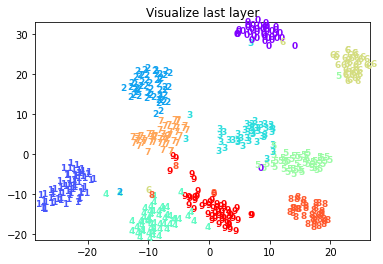

Test Loss: 0.000212, Accuracy: 9683/10000 (96.83%
epoch 5
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.096930
Train Epoch: 5 [1000/60000 (2%)]	Loss: 0.038015
Train Epoch: 5 [2000/60000 (3%)]	Loss: 0.081893
Train Epoch: 5 [3000/60000 (5%)]	Loss: 0.000902
Train Epoch: 5 [4000/60000 (7%)]	Loss: 0.107726
Train Epoch: 5 [5000/60000 (8%)]	Loss: 0.514646
Train Epoch: 5 [6000/60000 (10%)]	Loss: 0.054469
Train Epoch: 5 [7000/60000 (12%)]	Loss: 0.066327
Train Epoch: 5 [8000/60000 (13%)]	Loss: 0.012210
Train Epoch: 5 [9000/60000 (15%)]	Loss: 0.079796
Train Epoch: 5 [10000/60000 (17%)]	Loss: 0.126746
Train Epoch: 5 [11000/60000 (18%)]	Loss: 0.124215
Train Epoch: 5 [12000/60000 (20%)]	Loss: 0.103200
Train Epoch: 5 [13000/60000 (22%)]	Loss: 0.003923
Train Epoch: 5 [14000/60000 (23%)]	Loss: 0.011091
Train Epoch: 5 [15000/60000 (25%)]	Loss: 0.118048
Train Epoch: 5 [16000/60000 (27%)]	Loss: 0.072796
Train Epoch: 5 [17000/60000 (28%)]	Loss: 0.102923
Train Epoch: 5 [18000/60000 (30%)]	Loss: 0.018608
Train Epoch

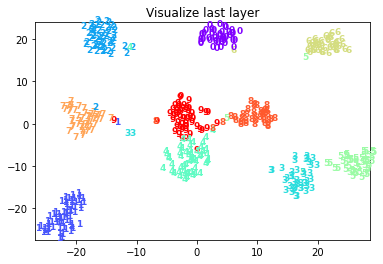

Test Loss: 0.000160, Accuracy: 9772/10000 (97.72%


In [165]:
"""准确率"""

def test():
    cnn.eval()
    eval_loss = 0
    eval_acc = 0
    # 打开imshow()交互模式:更新图像后直接执行以后的代码,不阻塞在plt.show()
    plt.ion()
    #无需反向传播计算梯度,不需要进行求导运算
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(test_loader):
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            out,last_layer = cnn(batch_x)
            loss = loss_func(out, batch_y)
            #loss =  += F.nll_loss(out, batch_y, size_average=False).item()
            eval_loss += loss.item()
            pred = torch.max(out, 1)[1]
            num_correct = (pred == batch_y).sum()
            eval_acc += num_correct.item()
            #若需绘图,将下面代码块注释去掉
            
            if step % 100 == 0:
                #t-SNE 是一种非线性降维算法，非常适用于高维数据降维到2维或者3维，进行可视化
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                #最多只画500个点
                plot_only = 500
                #fit_transform函数把last_layer的Tensor降低至2个特征量,即3个维度(2个维度的坐标系)
                low_dim_embs = tsne.fit_transform(last_layer.cpu().data.numpy()[:plot_only, :])
                labels = batch_y.cpu().numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
            
            #若需绘图,将上面代码块注释去掉 
    print('Test Loss: {:.6f}, Accuracy: {}/{} ({:.2f}%'.format(eval_loss / (len(test_data)),eval_acc, len(test_data) ,100.*eval_acc / (len(test_data))))
    plt.ioff()

for epoch in range(1, 6):
    train(epoch)
    test()